In [2]:
# MAJA L2A and CAMS visu tools
# Adapted from mtools (https://github.com/jerome-colin/mtools)

# TODO: consolidate with exceptions

# Requirements:
import netCDF4 as nc
import numpy as np
import pylab as pl
import osgeo.gdal as gdal
import glob
from PIL import Image as pillow
from skimage import measure
from datetime import date, timedelta, datetime

## Internal functions (jump to next section for usefull ones, refrain from modifying the ones starting with '_')

def _count_nan(arr):
    """
    Count the number of NaN in arr
    :param arr:
    :return: integer
    """
    return np.count_nonzero(np.isnan(arr))


def _count_not_nan(arr):
    """
    Count the number of NaN in arr
    :param arr:
    :return: integer
    """
    return np.count_nonzero(~np.isnan(arr))

def _convert_band_uint8(band, vmin=0, vmax=None):
    """Convert a band array to unint8
    :return: an unint8 numpy array
    """
    if vmax == None:
        b_max = np.nanmax(band)
    else:
        b_max = vmax

    clipped_band = np.clip(band, vmin, b_max)

    if b_max > 0:
        img = clipped_band / b_max * 256
    else:
        img = clipped_band * 0

    return img.astype(np.uint8)
    
def _find_band(band, content_list):
        fband_name = [b for b in content_list if band in b]
        if len(fband_name) == 1:
            print("Found file %s for band name %s" % (fband_name[0], band))
            return fband_name[0]
        else:
            print("No match found for band name %s" % band)

def _geo_idx(dd, dd_array):
    """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx
            
def _get_content_list(path):
        return glob.glob(path + '/*')

def _hours2date(nb_hours):
    """
    :nb_hours: int, hours since 1900-01-01 00:00:00 from CAMS
    :return: datetime, YYYY-MM-DD HH:MM:SS
    """
    start = datetime(1900,1,1)
    delta = timedelta(int(nb_hours)/24)
    offset = start + delta
    return offset
    
def _open_img(filename, scalef=None):
    if scalef is not None:
        return gdal.Open('%s' % (filename)).ReadAsArray() / scalef
    else:
        return gdal.Open('%s' % (filename)).ReadAsArray()
    
## Basic L2 functions (see docstrings for info, and next cells for examples of use)

def get_band(path, band, scalef=10000):
    """
    Get a L2A band as ndarray
    :path: str, full path to Maja directory, no trailing /
    :band: str, band name pattern, eg. "FRE_B3"
    :scalef: float, reflectance scale factor
    :return: a ndarray of the tif file
    """
    filename = _find_band(band, _get_content_list(path))
    return _open_img(filename, scalef)

def get_clm(path):
    """
    Get the MAJA Cloud mask (R1) as ndarray
    :path: str, full path to Maja directory, no trailing /
    :return: a ndarray of the CLM_R1 file
    """
    return _open_img(_find_band("CLM_R1", _get_content_list(path + "/MASKS")))

def get_edg(path):
    """
    Get the MAJA Edge mask (R1) as ndarray
    :path: str, full path to Maja directory, no trailing /
    :return: a ndarray of the EDG_R1 file
    """
    return _open_img(_find_band("EDG_R1", _get_content_list(path + "/MASKS")))

def get_mg2(path):
    """
    Get the MAJA MG2 mask (R1) as ndarray
    :path: str, full path to Maja directory, no trailing /
    :return: a ndarray of the MG2_R1 file
    """
    return _open_img(_find_band("MG2_R1", _get_content_list(path + "/MASKS")))

def get_isvalid_mask(clm, edg, stats=False, use_nodata=False):
    """
    Return a 'validity mask' such that valid pixel is 1, non-valid pixel is 0
    :param clm: cloud mask numpy array
    :param edg: edge mask numpy array
    :param stats: return a fraction of valid pixels in percent
    :param use_nodata: if True, NaN in masks are used instead of 0
    :return: an array with 'valid' = 1, 'non-valid' = 0
    """

    # TODO: consider revising (numpy.ma ?)
    clm = clm
    edg = edg

    dummy = np.zeros_like(clm) + 1
    print("Dummy size=%i, sum=%i" % (np.size(dummy), np.sum(dummy)))

    if use_nodata:
        dummy[~np.isnan(clm)] = 0
        dummy[~np.isnan(edg)] = 0
    else:
        dummy[np.nonzero(clm)] = 0
        dummy[np.nonzero(edg)] = 0

    validity_ratio = np.nansum(dummy) / np.size(clm) * 100

    print("isvalid_mask: NaN in clm=%i, NaN in edg=%i, Non-zero in mask=%i, result=%i, ratio=%4.2f%%" %
                      (_count_nan(clm), _count_nan(edg), np.count_nonzero(dummy), np.nansum(dummy),
                       validity_ratio))

    if stats:
        return dummy, validity_ratio
    else:
        return dummy

def is_valid(band, mask, target=1):
    """
    Return a vector of pixels from the array 'band' that match 'mask'=1
    :param band:
    :param mask:
    :return: a numpy vector
    """
    search = np.where(mask == target)
    valid_pixels = band[search]
    return valid_pixels

def quicklook(r, g, b, mask=None, vmax=0.5, outfile=None):
    """
    Generate a quicklook
    :param r: band array
    :param g: band array
    :param b: band array
    :mask: is_valid mask array from get_isvalid_mask. If provided, valid pixels will be outlined in green
    :param outfile: str
    :return: void
    """

    if mask is None:
        pl.imshow(np.dstack((_convert_band_uint8(r, vmax=vmax),
                             _convert_band_uint8(g, vmax=vmax),
                             _convert_band_uint8(b, vmax=vmax))),
                            interpolation='none',
                            aspect='equal')
        
    if mask is not None:
        contours = measure.find_contours(mask, 0)
        fig, ax = pl.subplots(figsize=(8,8))
        ax.imshow(np.dstack((_convert_band_uint8(r, vmax=vmax),
                             _convert_band_uint8(g, vmax=vmax),
                             _convert_band_uint8(b, vmax=vmax))),
                            interpolation='none',
                            aspect='equal')

        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], 'g-', linewidth=2)

        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
    
    if outfile is not None:
        pl.savefig(outfile)
        
## CAMS netCDF functions

def get_cams_dataset(path, name):
    """
    Return the netCDF dataset for 'name' from a given fullpath
    :path: full path to CAMS product
    :name: should be 'AOT', 'MR' or 'RH'
    :return: dataset object (netCDF4 like)
    """
    return nc.Dataset(_find_band(name, _get_content_list(path)))
    
def get_cams_subset(ds, varname, lat_min, lat_max, long_min, long_max):
    """
    Net yet implemented
    """
    pass

def get_list_aerosols(kind=7):
    """
    Return a list of CAMS aerosols variable names
    :kind: int, defaults to 7 for the seven combination (after 2019/07/10), or 5
    """
    if kind == 7:
        return ['ssaod550', 'duaod550', 'omaod550', 'bcaod550', 'amaod550', 'suaod550', 'niaod550']
    elif kind == 5:
        return ['ssaod550', 'duaod550', 'omaod550', 'bcaod550', 'suaod550']
    else:
        print("ERROR: kind is either 5 or 7")

def get_local_aot(ds, list_aot, in_lat, in_lon):
    """
    Print AODs and contribution in % for a given list of aerosols 
    :ds: netCDF CAMS AOT dataset (see get_aot())
    :list_aot: a list of aerosols as CAMS variable names (see get_list_aerosols())
    :in_lat: input latitude in DD
    :in_lon: input longitude in DD
    :return: prints statistics
    """
    lats = ds['latitude'][:]
    lons = ds['longitude'][:]

    lat_idx = _geo_idx(in_lat, lats)
    lon_idx = _geo_idx(in_lon, lons)
    
    print("Closest index for lat %8.6f, lon %8.6f is (%i, %i) (%4.2f, %4.2f)" % (in_lat, in_lon, lat_idx, lon_idx, lats[lat_idx], lons[lon_idx]))
    
    aods = np.zeros(len(list_aot))
    for i in range(len(list_aot)):
        aods[i] = ds[list_aot[i]][0, lat_idx, lon_idx]
        
    for i in range(len(aods)):
        print("%s : %8.6f (%4.3f%%)" % (list_aot[i], aods[i], aods[i]/sum(aods)*100)) 
    


def summary(ds, detailed=False):
    """
    Print a summary of a CAMS netCDF file
    :ds: netCDF dataset (see for an example get_aot())
    :detailed: print full var message instead of the easier to read formatted default message
    """
    ds_time = ds['time'][:]
    if len(ds_time) == 1:
        timestamp = _hours2date(ds_time[0])
        print("Single timestep found: %s" % str(timestamp))
    else:
        print("WARNING: Many time steps found in file!")

    print("Content:")
    for var in ds.variables.values():
        if detailed:
            print(var)
        else:
            try:
                print("%s (%s), with shape %s" % (var.long_name, var.units, str(var.shape)))
            except AttributeError:
                print("%s, with shape %s" % (var.long_name, str(var.shape)))

In [6]:
# Declare path to L2A products

# Processed by Muscate. 100% cloud covered...
path_19_newapi = "/work/OT/muscate/test/echange/cams_ads/avant_juillet2019/ECMWF/SENTINEL2B_20180403-104105-360_L2A_T31TFJ_C_V1-0"
path_19_oldapi = "/work/OT/muscate/test/echange/cams_ads/avant_juillet2019/ECMWF/grille_agrandie/SENTINEL2B_20180403-104105-360_L2A_T31TFJ_C_V1-0"

# Processed by Muscate. Old API points to 'consolidated' CAMS, while new API points to 'real time' CAMS products
path_21_oldapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0"
path_21_newapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0"

In [7]:
# Load B2, B3, B4, EDG_R1 and CLM_R1, create an is_valid mask...

#...for both old CAMS API
b2_21_oldapi = get_band(path_21_oldapi, "FRE_B2")
b3_21_oldapi = get_band(path_21_oldapi, "FRE_B3")
b4_21_oldapi = get_band(path_21_oldapi, "FRE_B4")
clm_21_oldapi = get_clm(path_21_oldapi)
edg_21_oldapi = get_edg(path_21_oldapi)
mask_oldapi, vstats_oldapi = get_isvalid_mask(clm_21_oldapi, edg_21_oldapi, stats=True)

#...and new CAMS API
b2_21_newapi = get_band(path_21_newapi, "FRE_B2")
b3_21_newapi = get_band(path_21_newapi, "FRE_B3")
b4_21_newapi = get_band(path_21_newapi, "FRE_B4")
clm_21_newapi = get_clm(path_21_newapi)
edg_21_newapi = get_edg(path_21_newapi)
mask_newapi, vstats_newapi = get_isvalid_mask(clm_21_newapi, edg_21_newapi, stats=True)


Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0_FRE_B2.tif for band name FRE_B2
Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0_FRE_B3.tif for band name FRE_B3
Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0_FRE_B4.tif for band name FRE_B4
Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0/MASKS/SENTINEL2B_20210524-103858-838_L2A_FranceMetropoleN002E008_C_V1-0_CLM_R1.tif for band name CLM_R1
Found file /work/OT/muscate/test/echange/c

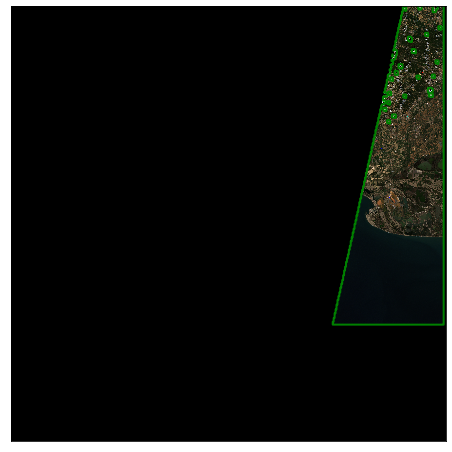

In [8]:
quicklook(b4_21_oldapi, b3_21_oldapi, b2_21_oldapi, mask=mask_oldapi, vmax=0.5, outfile="quicklook_20210524.png")

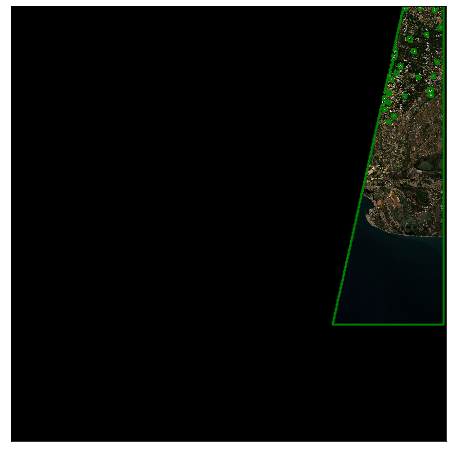

In [9]:
quicklook(b4_21_newapi, b3_21_newapi, b2_21_newapi, mask=mask_newapi, vmax=0.5)

In [10]:
# is_valid mask is of different length for old/new. The following mask identifies common valid pixels with value '2'
common_valid = mask_oldapi + mask_newapi

In [11]:
def plot_fre(b_name, oldband, newband, common_mask):
    """
    Scatterplot function
    """
    fig = pl.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.set_title("L2A %s 31TFJ 2021-05-24" % b_name)
    ax.set_xlabel("Cloud-free %s FRE with old CAMS API" % b_name)
    ax.set_ylabel("Cloud-free %s FRE with new CAMS API" % b_name)

    ax.plot([0, 2], [0, 2], 'r-')
    ax.plot(is_valid(oldband, common_mask, target=2), is_valid(newband, common_mask, target=2), 'b.')
    pl.savefig("%s_intercomp_cams.png" % b_name)

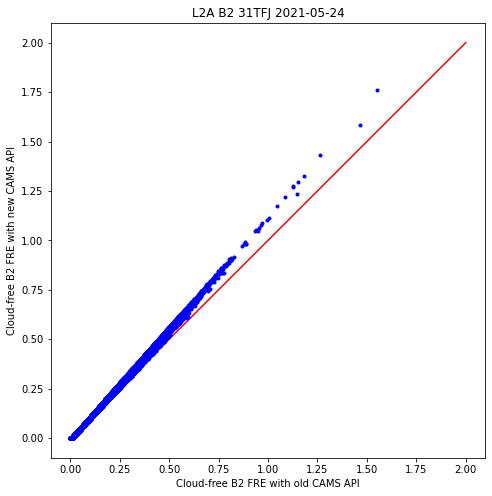

In [12]:
plot_fre("B2", b2_21_oldapi, b2_21_newapi, common_valid)

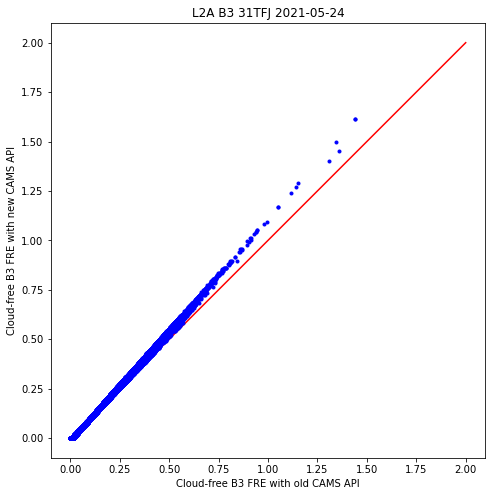

In [13]:
plot_fre("B3", b3_21_oldapi, b3_21_newapi, common_valid)

In [ ]:
plot_fre("B4", b4_21_oldapi, b4_21_newapi, common_valid)

In [3]:
# Get the list of aerosols variable names
aerosols = get_list_aerosols()

# Get summary of AOT with old API CAMS
cams_21_oldapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/CAMS_TR_20210524T120000"
aot_21_oldapi = get_cams_dataset(cams_21_oldapi, 'AOT')
summary(aot_21_oldapi)
get_local_aot(aot_21_oldapi, aerosols, 43.676667, 4.627778) # Arles

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/CAMS_TR_20210524T120000/CAMS_AOT_TR_20210524UTC120000.nc for band name AOT
Single timestep found: 2021-05-24 12:00:00
Content:
longitude (degrees_east), with shape (288,)
latitude (degrees_north), with shape (145,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Sea Salt Aerosol Optical Depth at 550nm (~), with shape (1, 145, 288)
Dust Aerosol Optical Depth at 550nm (~), with shape (1, 145, 288)
Organic Matter Aerosol Optical Depth at 550nm (~), with shape (1, 145, 288)
Black Carbon Aerosol Optical Depth at 550nm (~), with shape (1, 145, 288)
Sulphate Aerosol Optical Depth at 550nm (~), with shape (1, 145, 288)
Nitrate aerosol optical depth at 550 nm (dimensionless), with shape (1, 145, 288)
Ammonium aerosol optical depth at 550 nm (dimensionless), with shape (1, 145, 288)
Closest index for lat 43.676667, lon 4.627778 is (37, 4) (43.75, 5.00)
ssaod550 : 0.002636 (2.483%)
duaod550 : 0.005512 (5.192%)
oma

In [4]:
# Get summary of AOT with new API CAMS
cams_21_newapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/CAMS_TR_20210524T000000"
aot_21_newapi = get_cams_dataset(cams_21_newapi, 'AOT')
summary(aot_21_newapi, detailed=False)
get_local_aot(aot_21_newapi, aerosols, 43.676667, 4.627778) # Arles

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/CAMS_TR_20210524T000000/CAMS_AOT_TR_20210524UTC000000.nc for band name AOT
Single timestep found: 2021-05-24 00:00:00
Content:
longitude (degrees_east), with shape (900,)
latitude (degrees_north), with shape (451,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Sea Salt Aerosol Optical Depth at 550nm (~), with shape (1, 451, 900)
Dust Aerosol Optical Depth at 550nm (~), with shape (1, 451, 900)
Organic Matter Aerosol Optical Depth at 550nm (~), with shape (1, 451, 900)
Black Carbon Aerosol Optical Depth at 550nm (~), with shape (1, 451, 900)
Sulphate Aerosol Optical Depth at 550nm (~), with shape (1, 451, 900)
Nitrate aerosol optical depth at 550 nm (dimensionless), with shape (1, 451, 900)
Geopotential (m**2 s**-2), with shape (1, 451, 900)
Ammonium aerosol optical depth at 550 nm (dimensionless), with shape (1, 451, 900)
Closest index for lat 43.676667, lon 4.627778 is (116, 12) (43.60, 4.80)
ssaod550 

In [5]:
# Get summary of MR new API CAMS
cams_21_oldapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/CAMS_TR_20210524T120000"
mr_21_oldapi = get_cams_dataset(cams_21_oldapi, 'MR')
summary(mr_21_oldapi, detailed=False)

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/CAMS_TR_20210524T120000/CAMS_MR_TR_20210524UTC120000.nc for band name MR
Single timestep found: 2021-05-24 12:00:00
Content:
longitude (degrees_east), with shape (288,)
latitude (degrees_north), with shape (145,)
model_level_number, with shape (137,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Sea Salt Aerosol (0.03 - 0.5 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Sea Salt Aerosol (0.5 - 5 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Sea Salt Aerosol (5 - 20 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Dust Aerosol (0.03 - 0.55 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Dust Aerosol (0.55 - 0.9 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Dust Aerosol (0.9 - 20 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Hydrophilic Organic Matter Aerosol Mixing Ratio (kg kg**-1), with shape (1, 137, 145, 288)
Hydrophobic 

In [6]:
# Get summary of MR new API CAMS
cams_21_newapi = "/work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/CAMS_TR_20210524T000000"
mr_21_newapi = get_cams_dataset(cams_21_newapi, 'MR')
summary(mr_21_newapi, detailed=False)

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/CAMS_TR_20210524T000000/CAMS_MR_TR_20210524UTC000000.nc for band name MR
Single timestep found: 2021-05-24 00:00:00
Content:
longitude (degrees_east), with shape (900,)
latitude (degrees_north), with shape (451,)
model_level_number, with shape (137,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Sea Salt Aerosol (0.5 - 5 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Sea Salt Aerosol (5 - 20 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Dust Aerosol (0.03 - 0.55 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Dust Aerosol (0.55 - 0.9 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Dust Aerosol (0.9 - 20 um) Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Hydrophilic Organic Matter Aerosol Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Hydrophobic Organic Matter Aerosol Mixing Ratio (kg kg**-1), with shape (1, 137, 451, 900)
Hydrophilic 

In [7]:
rh_21_oldapi = get_cams_dataset(cams_21_oldapi, 'RH')
summary(rh_21_oldapi, detailed=False)

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ECMWF/CAMS_TR_20210524T120000/CAMS_RH_TR_20210524UTC120000.nc for band name RH
Single timestep found: 2021-05-24 12:00:00
Content:
longitude (degrees_east), with shape (288,)
latitude (degrees_north), with shape (145,)
pressure_level (millibars), with shape (22,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Relative humidity (%), with shape (1, 22, 145, 288)


In [8]:
rh_21_newapi = get_cams_dataset(cams_21_newapi, 'RH')
summary(rh_21_newapi, detailed=False)

Found file /work/OT/muscate/test/echange/cams_ads/apres_juillet2019/ADS/CAMS_TR_20210524T000000/CAMS_RH_TR_20210524UTC000000.nc for band name RH
Single timestep found: 2021-05-24 00:00:00
Content:
longitude (degrees_east), with shape (900,)
latitude (degrees_north), with shape (451,)
pressure_level (millibars), with shape (22,)
time (hours since 1900-01-01 00:00:00.0), with shape (1,)
Relative humidity (%), with shape (1, 22, 451, 900)
